<h1><font color='red'> THIS IS A SAMPLE SOLUTION FOR KNN WITH BOW REPRESENTATION OF ESSAY AND FEW OTHER FEATURES. <br><br> CONSIDERED ONLY 5K DATA POINTS, FOR YOUR ASSIGNMENT YOU MIGHT NEED TO CONSIDER ATLEAST 50K DATA POINTS, AND EXTRA FEATURES THAT ARE PROVIDED IN THE INSTRUCTIONS</font></h1>

In [56]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

ImportError: 
The plotly.plotly module is deprecated,
please install the chart-studio package and use the
chart_studio.plotly module instead. 


<h1>1. K Nearest Neighbor</h1>

## 1.1 Loading Data

In [58]:
data  = pd.read_csv('preprocessed_data.csv')
# data  = pd.read_csv('preprocessed_data.csv', nrows=50000) # you can take less number of rows like this
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [110]:
data.shape

(109248, 9)

In [59]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [60]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [61]:
ex = ["classroom students should take break",
"low income homes students receive free breakfast",
"students will receive low grades"]
vectorizer = CountVectorizer()
vectorizer.fit(tqdm(ex))
print(vectorizer.transform(ex).toarray())
print(vectorizer.get_feature_names())

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3006.67it/s]

[[1 0 1 0 0 0 0 0 0 1 1 1 0]
 [0 1 0 1 0 1 1 1 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 1 0 1 0 1]]
['break', 'breakfast', 'classroom', 'free', 'grades', 'homes', 'income', 'low', 'receive', 'should', 'students', 'take', 'will']


In [62]:

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(tqdm(X_train['essay'].values))
X_cv_essay_bow = vectorizer.transform(tqdm(X_cv['essay'].values))
X_test_essay_bow = vectorizer.transform(tqdm(X_test['essay'].values))

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

print("="*100)


# print("YOU SHOULD NOT DO SOMETHING LIKE THIS")
# vectorizer = CountVectorizer()
# x_train_bow = vectorizer.fit_transform(X_train['essay'].values)
# x_cv_bow = vectorizer.fit_transform(X_cv['essay'].values)
# x_test_bow = vectorizer.fit_transform(X_test['essay'].values)

# print(x_train_bow.shape, y_train.shape)
# print(x_cv_bow.shape, y_cv.shape)
# print(x_test_bow.shape, y_test.shape)

print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")


(49041, 8) (49041,)
(24155, 8) (24155,)
(36052, 8) (36052,)


100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [00:40<00:00, 892.84it/s]


After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


<pre>
<h2> <font color='red'>YOU SHOULD NOT DO LIKE THIS </font></h2>
1.  <font color='red'>THE VOCABULARY SHOULD BUILT ONLY WITH THE WORDS OF TRAIN DATA</font>
    vectorizer = CountVectorizer()
    x_train_bow = vectorizer.fit_transform(X_train)
    x_cv_bow = vectorizer.fit_transform(X_cv)
    x_test_bow = vectorizer.fit_transform(X_test)
    
2.  <font color='red'>DATA LEAKAGE PROBLEM: IF WE DO LIKE THIS WE ARE LOOKING AT THE TEST DATA BEFORE MODELING</font>
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transfomr(X)
    X_train, X_test, y_train, y_test = train_test_split(X_bow, Y, test_size=0.33)
   
3. <font color='red'>YOU SHOULD PASS THE PROBABILITY SCORES NOT THE PREDICTED VALUES</font>
    y_pred =  neigh.predict(X)
    roc_auc_score(y_ture,y_pred)


</pre>

<pre>
<h2> <font color='red'>WHAT ARE THESE FUNCTIONS: FIT, TRANSFORM, FIT_TRANSFORM</font></h2>

When you do
<i><font color='blue'>vec =  CountVectorizer()</font></i>

then it will initiate the <i><font color='blue'>CountVectorizer</font></i> with default parameters.

<i><font color='blue'>vec.fit(Train_text)</font></i>: Means that internally it is only learning the vocabulary of `Text` i.e. unique n-grams

<i><font color='blue'>bag_of_words = vec.transform(Train_text)</font></i>: Means it is applying that learned parameters (vocabulary) to the data and thus giving you output i.e. words in Bag of words formate. 

Now, as you should know that the  <i>vocabulary(unique n-grams)</i> can be different for <i>Train Text</i> and <i>Test Text</i> thus they will give you different dimensional matrices for Train and Test. 

So what you should do is -  <i><font color='blue'>vec = CountVectorizer()</font></i>, <i><font color='blue'>vec.fit(Train_text)</font></i>

which learns the vocabulary of <i>Train Text</i> and then apply or transform your both <i>Train Text</i> and <i>Test Text</i>  using that  
learned vocabulary to ensure the same dimensions for both of them by doing -

<i><font color='blue'>bag_of_words_train = vec.transform(Train_text)</font></i>
and
<i><font color='blue'>bag_of_words_test = vec.transform(Test_text)</font></i>


so to conclude

<i><font color='blue'>
model =  CountVectorizer()
model.fit(train_text)
train_bow = model.transform(train_text)
test_bow = model.transform(test_text) 
</font></i>

or 
   
<i><font color='blue'>
model =  CountVectorizer()
train_bow = model.fit_transform(train_text)
test_bow = model.transform(test_text) 
</font></i>


</pre>

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 encoding categorical features: School State</h3>

In [63]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(tqdm(X_train['school_state'].values))
X_cv_state_ohe = vectorizer.transform(tqdm(X_cv['school_state'].values))
X_test_state_ohe = vectorizer.transform(tqdm(X_test['school_state'].values))

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:00<00:00, 74047.02it/s]

After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3>1.4.2 encoding categorical features: teacher_prefix</h3>

In [64]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(tqdm(X_train['teacher_prefix'].values))
X_cv_teacher_ohe = vectorizer.transform(tqdm(X_cv['teacher_prefix'].values))
X_test_teacher_ohe = vectorizer.transform(tqdm(X_test['teacher_prefix'].values))

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:00<00:00, 58836.41it/s]

After vectorizations
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


<h3>1.4.3 encoding categorical features: project_grade_category</h3>

In [65]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h3>1.4.4 encoding numerical features: Price</h3>

In [100]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.


normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))




print("After vectorizations")

print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [101]:
np.array(X_cv['price']).reshape(-1,1).shape

(24155, 1)

# <font color='red'> Simarly you can convert reminaing features into vectors </font>


### 1.4.5 Concatinating all the features

In [102]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 5061) (49041,)
(24155, 5061) (24155,)
(36052, 5061) (36052,)


<h2>1.5 Appling KNN on different kind of featurization as mentioned in the instructions</h2>

<h3>1.5.1 Appling KNN: BOW featurization</h3>

#### 1.5.1.1 Hyper parameter Tuning (YOU CAN FOLLOW ANY ONE OF THESE)

##### 1.5.1.1.1 Method 1: Simple for loop (if you are having memory limitations use this)

In [103]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [27:31<00:00, 330.34s/it]


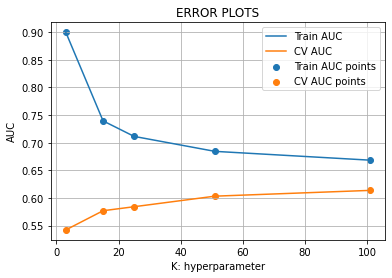

In [104]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

##### 1.5.1.1.2 Method 1: Simple for loop (if you are having memory limitations use this)

In [143]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

neigh = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':[3, 15, 25, 51, 101]}
clf = RandomizedSearchCV(neigh, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

KeyboardInterrupt: 

In [124]:
clf.best_params_

{'n_neighbors': 101}

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [120]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 95

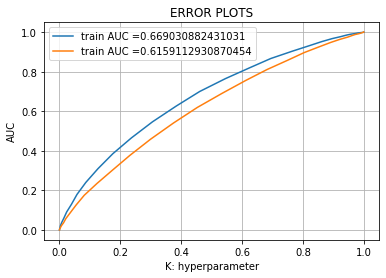

In [121]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [122]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [123]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3861050562918865 for threshold 0.821
Train confusion matrix
[[ 4576  2850]
 [15540 26075]]
Test confusion matrix
[[ 2986  2473]
 [11639 18954]]


<pre>

<h3><font color='blue'>IF Your system is getting stuck when you are working with the Knn: <font color='green'>YOU NEED TO USE BATCH WISE PREDICTION</font></font></h3>

neigh = KNeighborsClassifier(n_neighbors=i)
neigh.fit(X_train_bow, y_train)

# instead of predicting all the data points at a time, we will predict 1000 data points at a time
# you might need to change this code as per requirement
# please try to debug errors on your own, read the errors and try to understand it.
# you should be able to resolve them on your own as you wrote that code :)
# use as many print statements as possible and make sure whats happening in the code
# read the documentation of functions and get the sense out of it

y_train_pred = []
for i in range(0, X_train.shape[0], 1000):
    y_train_pred.extend(neigh.predict_proba(X_train_bow[i,i+1000])[:,1]) # this is a pseudo code

y_cv_pred = []
for i in range(0, X_cv.shape[0], 1000):
    y_cv_pred.extend(neigh.predict_proba(X_cv_bow[i,i+1000])[:,1]) # this is a pseudo code
    

train_auc.append(roc_auc_score(y_train,y_train_pred))
cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


</pre>

<h3>1.5.3 Appling KNN: AVG W2V featurization</h3>

In [125]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [126]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))
print(avg_w2v_vectors_train[0])

100%|██████████████████████████████████████████████████████████████████████████| 49041/49041 [00:48<00:00, 1005.47it/s]

49041
300
[-3.54741321e-02  3.69612714e-02  1.19378191e-02 -6.55917481e-02
 -9.89233282e-03 -7.13432733e-02 -3.18060103e+00  1.00822021e-01
  4.76131351e-02  1.33266786e-01 -8.20986260e-02  1.39766811e-02
  1.53628611e-02 -9.58749969e-02  1.09157077e-02 -1.51941954e-02
  6.18031298e-02 -9.99302885e-02  1.07880505e-01  2.94170229e-02
 -2.06145336e-02  2.47563878e-02 -2.30053435e-02 -5.56433382e-02
  1.21660214e-02 -6.64323466e-03  1.26186415e-01 -6.02554115e-02
  9.79392443e-03 -4.56168191e-02 -2.58877129e-01 -7.43050298e-02
  7.45892153e-02  5.71194290e-02 -7.43046756e-02 -3.90030489e-02
 -6.88597084e-02 -4.50544328e-02 -6.19370031e-02 -2.10860458e-03
 -7.29733721e-02  2.87494435e-02  4.75339527e-02 -1.54413927e-01
  2.60397275e-02 -7.89689805e-02  7.25828214e-02 -5.10906527e-02
  4.96281382e-02 -1.32615169e-01  1.99998246e-02 -4.00984366e-02
  1.30568344e-02 -6.09044809e-02  3.97954364e-02 -8.07444290e-02
  2.38740721e-02 -1.60683537e-02 -8.98048634e-02  1.09133586e-01
 -2.24970412e-0

In [127]:
avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:17<00:00, 1343.92it/s]


In [131]:
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:30<00:00, 1193.09it/s]


In [138]:
X_Tr = hstack((avg_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm)).tocsr()
X_Cr = hstack((avg_w2v_vectors_cv, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm)).tocsr()
X_Te = hstack((avg_w2v_vectors_test, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 361) (49041,)
(24155, 361) (24155,)
(36052, 361) (36052,)


#### 1.5.3.1 Hyper parameter Tuning

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:29:37<00:00, 1075.60s/it]
Exception ignored in: <function tqdm.__del__ at 0x0000022187FE7790>
Traceback (most recent call last):
  File "C:\Users\Nihar\anaconda3\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\Nihar\anaconda3\lib\site-packages\tqdm\std.py", line 1264, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'


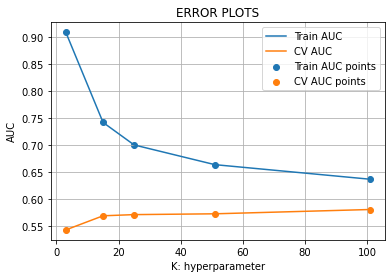

In [139]:
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_Tr, y_train)

    y_train_pred = batch_predict(neigh, X_Tr)   
    y_cv_pred = batch_predict(neigh, X_Cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [140]:
best_k = 101

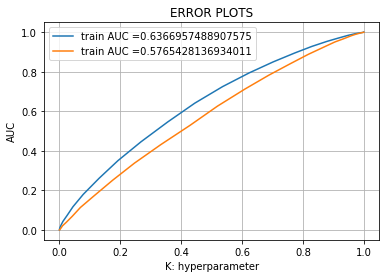

In [141]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [142]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.35602808619235116 for threshold 0.851
Train confusion matrix
[[ 4122  3304]
 [14923 26692]]
Test confusion matrix
[[ 2625  2834]
 [11440 19153]]
